# Sentiment Analysis for Product reviews

This assessment contains the following  :
- The code for text pre-processing
- Exploratory Data Analysis
- Feature Generation and Selection
- Building 3 Models
- The code for training and testing classifier


This notebook consists of the following contents

- [Introduction](#sec_1)
- [Pre-Processing](#sec_3)
- [EDA](#sec_6)
- [Feature Extraction](#sec_4)
- [Sentiment Classifers](#sec_5) 
- [Conclusion](#sec_5)

# Introduction <a class="anchor" id="sec_1"></a> 

In this assessment, we are developing a Sentiment analysis Classifier based on a large set of product reviews by Yelp.
The aim of this challenge is to develop a sentiment classifier that can assign a large set of
product reviews to the five levels of polarity of opinion as accurately as possible, given a small
amount of labeled reviews and a large amount of unlabelled reviews. It is a multi-class classification
task, where each product review is labeled with one of the five sentiment labels, which are strong
negative, weak negative, neutral, weak positive, and strong positive.

The datasets provided are :

- **labeled data.csv:**
It contains review text and sentiment labels with 50,000 product reviews, each
of which is annotated with the corresponding sentiment label.The label set (1,2,3,4,5) refer to five polarity levels (strong negative, weak negative, neutral, weak positive, strong and
positive)


- **unlabelled data.csv:**
It contains review text only and 600,000 product review without labels.This data set is used in training.


- **test data.csv:**
It contains test id and review text. It contains 50,000 product reviews which acts as the
testing data. 


The data is pre-processed using various techniques like removing special characters, removing spaces.

We would be selecting relevant features using Tf-idf, Word2vec methods.

In this assessment, we are comparing three different types of classification methods. The sentiment classifer which gives the most accurate prediction is finalised.

The evaluation method used in testing the accuracy score is given by :




\begin{equation}
Accuracy = \frac{number  of  correct  predictions}{number of all predictions}
\end{equation}


# Importing Libraries


In [36]:
#libraries required for pre-processing and model building
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import nltk
from nltk.tokenize import MWETokenizer
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn import metrics
import numpy as np
from nltk.stem import WordNetLemmatizer
import re
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical
from numpy import argmax
import tensorflow as tf
from numpy.random import seed
from sklearn.metrics import confusion_matrix
import logging
from sklearn.ensemble import VotingClassifier

# Miscellaneous Functions

In [37]:
#function to calculate accuracy
def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()


In [38]:
#function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Loading the data



## Train data

In [39]:
#loading labeled_data.csv
lab_data = pd.read_csv('labeled_data.csv')

#loading unlabeled_data.csv
unlabeled_data = pd.read_csv('unlabeled_data.csv')

## Test Data

In [40]:
#loading test_data.csv
test_data = pd.read_csv("test_data.csv")

# Pre-processing <a class="anchor" id="sec_3"></a> 

## Removing the rare words

#### Labeled data

In [41]:
#Finding the least frequent words in labeled data
freq = pd.Series(' '.join(lab_data['text']).split()).value_counts()[-10:]
print("The least frequent words in labeled data are :\n",freq)

The least frequent words in labeled data are :
 20/mbps         1
wrong)?         1
lamest          1
impressive--    1
pensais         1
Oooookay....    1
igual,el        1
5:40pm!         1
9-?             1
Radiant         1
dtype: int64


In [42]:
freq = list(freq.index)
#removing the words from labeled data
lab_data['text'] = lab_data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))


#### Unlabeled data

In [43]:
#Finding the least frequent words in unlabeled data
freq = pd.Series(' '.join(unlabeled_data['text']).split()).value_counts()[-10:]
print("The least frequent words in unlabeled data are :\n",freq)


The least frequent words in unlabeled data are :
 judge--life         1
Efendi,             1
-$44                1
tone...just         1
diavolo---tasted    1
Marlyin's           1
pomodoro:           1
known-fact.         1
salty...Overall,    1
"Michigan           1
dtype: int64


In [44]:
freq = list(freq.index)
#removing the rare words from unlabeled data
unlabeled_data['text'] = unlabeled_data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))


## Removing the 10 most frequent words

We tried removing the top 10 most frequent words. As the accuracy of the model decreased, we decided not to remove the words. Hence,the code below is commented.

#### Labeled data

In [45]:
#freq = pd.Series(' '.join(lab_data['text']).split()).value_counts()[:10]
#print("The rare words in labeled data are :\n",freq)

In [46]:
#freq = list(freq.index)
#lab_data['text'] = lab_data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

#### Unlabeled data

In [47]:
#freq = pd.Series(' '.join(unlabeled_data['text']).split()).value_counts()[:10]
#print("The rare words in labeled data are :\n",freq)

In [48]:
#freq = list(freq.index)
#lab_data['text'] = unlabeled_data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

# Removing special characters and numbers 

The characters removed from the corpus are :

- \n : Line separator 
- \r : Line separator
- numbers 
- \\'

In [49]:
def remove_extra_characters(raw_text):
    #remove \n
    processed_text = re.sub('\\n','', raw_text)
    #remove \r
    processed_text = re.sub('\\r','', processed_text)
    #remove \' and replace with '
    processed_text = re.sub("\\'", "\'",processed_text)
    #remove numbers
    processed_text = re.sub(r'\d+','', processed_text)
    return processed_text

In [50]:
#using the remove_extra_characters function removing the characters from labeled_data
lab_data['text'] = lab_data.apply(lambda row: remove_extra_characters(row['text'].strip()), axis=1)

In [51]:
#using the remove_extra_characters function removing the characters from unlabeled_data
unlabeled_data['text'] = unlabeled_data.apply(lambda row: remove_extra_characters(row['text'].strip()), axis=1)

# Lemmatization

Initially, Lemmatization was used with the help of the code mentioned below. As the model gave lower accuracy, Lemmatization was not considered.

Hence, the below code is commented.

In [52]:
# def lemmatization(token_list):
#     lemmatizer = WordNetLemmatizer()
#     lem_token = []
#     for each in token_list :
#         lem_token.append(lemmatizer.lemmatize(each))
#     return lem_token

# Stemming

Stemming was taken into consideration initially. As the final model gave lower accuracy we decided not to use stemming. We have commented out the below stemming code.

In [53]:
#from nltk.stem.porter import PorterStemmer 
#def stemmer(review):
#   review = review.lower()  
#    review = review.split()        
#    ps = PorterStemmer()        
    # loop for stemming each word 
    # in string array at ith row     
#    review1 = [ps.stem(word) for word in review ]
#    processed_data = ' '.join(review1)
#    return processed_data

In [54]:
#lab_data['text'] = lab_data.apply(lambda row: stemmer(row['text'].strip()), axis=1)

In [55]:
#lab_data['text'] = lab_data.apply(lambda row: stemmer(row['text'].strip()), axis=1)

# Stop words removal

We removed stopwords using NLTK "stopwords_en.txt"

It was observed that the accuracy of the final was lower when the stopwords were removed.

Hence, we have taken the stopwords into account.


In [56]:
# stopwords = []
# with open('./stopwords_en.txt') as f:
#     stopwords = f.read().splitlines()
# stopwords = set(stopwords)

In [57]:
# def token(raw_data):
#     raw_data1 = raw_data.lower()
#     tokenised = tokenizer.tokenize(raw_data1)
#     stopwords_tokens = [w for w in tokenised if not w in stopwords]
#     processed_data = ' '.join(stopwords_tokens)
#     return(processed_data)

# Tokenization

In [58]:
#removes special characters and considers apostrophe
tokenizer = RegexpTokenizer("\w+(?:[']\w+)?")

In [59]:
def token(raw_data):
    #lower case
    raw_data1 = raw_data.lower()
    #tokenisation
    tokenised = tokenizer.tokenize(raw_data1)
    processed_data = ' '.join(tokenised)
    return(processed_data)

In [60]:
lab_data['text'] = lab_data.apply(lambda row: token(row['text'].strip()), axis=1)

In [61]:
unlabeled_data['text'] = unlabeled_data.apply(lambda row: token(row['text'].strip()), axis=1)

# EDA <a class="anchor" id="sec_6"></a> 

Different Data Analysis attempts to  provide any unstructured data into a meaningful data. Here, to understand the given text data to identify the extent to  which how different machine learning algorithms could elevate the current data.The above pre-processing steps performed on the data was helpful in making a consistent world cloud.

### 1. Word Cloud for Most Frequently used words:
Exploring the tone of the given data can be done by knowing the  most frequently used words because it would provide the common basis of the data. 

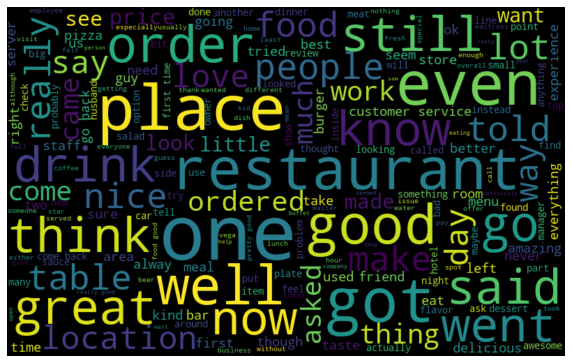

In [62]:
all_words = ' '.join([text for text in lab_data['text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### 2. Word Cloud for Strongly positive words:
This would provide a strong positive bias in human expression. It defines the emotional content of the data.

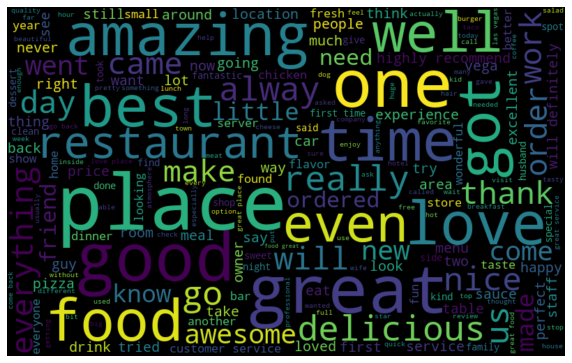

In [63]:
normal_words =' '.join([text for text in lab_data['text'][lab_data['label'] == 5]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Inference :

The plot above shows wordcloud with label '5' ie strongly positive.


<Figure size 72x144 with 0 Axes>

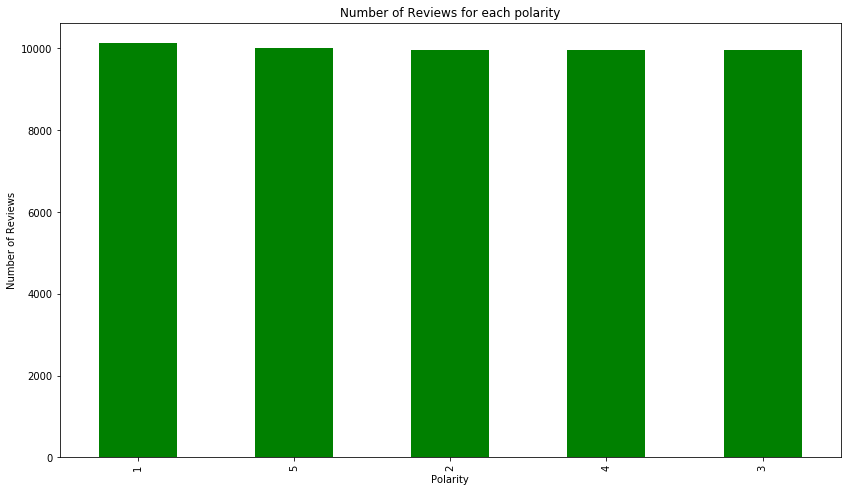

<Figure size 72x144 with 0 Axes>

In [64]:
ax = lab_data['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    color = 'green',
                                    title="Number of Reviews for each polarity")
ax.set_xlabel("Polarity")
ax.set_ylabel("Number of Reviews")
plt.figure(figsize=(1, 2))


# Feature Selection <a class="anchor" id="sec_4"></a> 

Feature Engineering is an important step in building the Sentiment Classifier.
We tried building models with TF-IDF Vectorizer and Word2VEc.

- **TF-IDF Vectorizer:** It estimates the term frequency (TF) of the word that is the occurrence of the word in the document and also estimates the inverse document frequency (IDF) of the word by calculating the log ratio of the number of documents where the word occurred to the total number of documents. It then assigns a weight to the word based on the TF and IDF. We made an attempt to use this vectorizer with bigrams and trigrams. It was observed that the bigrams gave the best results.

- **Word2vec:** It is a method that is used to provide vector representations of the words known as word embeddings. It generates low dimensional vectors for the words of very large-datasets. As we have labeled and unlabeled data, we generated a word embedding model using the entire datasets. We made an attempt to use this vectorizer to generate features for analysis but after applying this on the models didn’t improve the accuracy of the model.


# Word2Vec
Merging labelled and unlabelled data leading to the creation of corpus adn building a wordnet on it. 

In [65]:
sentences = []

for review in lab_data['text']:
    sentences.append(review.split())

for review in unlabeled_data['text']:
    sentences.append(review.split())

In [66]:
import gensim

# Set values for various parameters
num_features = 200    # Word vector dimensionality                      
num_workers = 4       # Number of threads to run in parallel

# Initialize and train the model
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count=1)

Training model...


In [67]:
words = list(model.wv.vocab)
print("Vocabulary size", len(words))

Vocabulary size 191867


In [68]:
model.wv.most_similar("horrible") 

[('terrible', 0.9640846848487854),
 ('awful', 0.8790841698646545),
 ('horrendous', 0.8430899381637573),
 ('atrocious', 0.7994617819786072),
 ('horrid', 0.7958575487136841),
 ('horrific', 0.7843879461288452),
 ('dreadful', 0.7298349142074585),
 ('lousy', 0.7217102646827698),
 ('aweful', 0.7028348445892334),
 ('abysmal', 0.7005771994590759)]

In [69]:
#saving the model
model.save("word2vec.model")

In [70]:
import logging
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

# Sentiment Classifiers  <a class="anchor" id="sec_5"></a> 

# Logistic Regression (word2vec)

#### Splitting data

In [71]:
#splitting the data
train, test = train_test_split(lab_data, test_size=0.3, random_state = 42)

In [72]:
def w2v_tokenize_text(text):
    tokens = text.split(' ')
    return tokens

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

In [73]:
X_train_word_average = word_averaging_list(model.wv,train_tokenized)
X_test_word_average = word_averaging_list(model.wv,test_tokenized)

C:\Users\seka0003\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  if __name__ == '__main__':


#### Logistic Regression(word2vec):
The Logistic Regression model takes the following parameters:
- random_state- which defines the result to be constant by setting it to one.
- solver is set to liblinear(linear classifier) method, which optimizes the sum of a finite number of smooth convex functions and is selected over SAG because it provides more accuracy 
- ovr - (binary relevance method)<br>
For Accuracy classification score, Accuracy_score was used from sklean. metrics as there exists multiclass labels. 

In [74]:
logreg = LogisticRegression(random_state=1, solver='liblinear', multi_class = 'ovr')
logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy of Logistic Regression(word2vec) %s' % metrics.accuracy_score(y_pred, test.label))


accuracy of Logistic Regression(word2vec) 0.5833333333333334


# NN (word2vec)

In [75]:
#splitting the data
train, test = train_test_split(lab_data, test_size=0.3, random_state = 42)

In [76]:
def w2v_tokenize_text(text):
    tokens = text.split(' ')
    return tokens

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

In [77]:
X_train_word_average = word_averaging_list(model.wv,train_tokenized)
X_test_word_average = word_averaging_list(model.wv,test_tokenized)

C:\Users\seka0003\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  if __name__ == '__main__':


In [78]:
model = Sequential()
model.add(layers.Dense(20, input_dim=num_features, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()
y_train = to_categorical(train['label'])
y_test = to_categorical(test['label'])
model.fit(X_train_word_average, y_train,
                     epochs=10,
                    verbose=False,
                     validation_data=(X_test_word_average, y_test),
                     batch_size=30)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                4020      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 126       
Total params: 4,146
Trainable params: 4,146
Non-trainable params: 0
_________________________________________________________________


In [79]:
y_pred = model.predict(X_test_word_average)
    
print("Accuracy of NN(word2vec): " + str(acc(y_test, y_pred)))

Accuracy of NN(word2vec): 0.5896666666666667


## Tf-IDF

The goal of using tf-idf is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer 

vectorizer = TfidfVectorizer(lowercase = True,analyzer = 'word',ngram_range = (1,2), min_df=3, max_df=.99)
    
train_review = vectorizer.fit_transform(lab_data['text'])

# Logistic Regression (Tfidf)

### Splitting the data

The labeled_data was divided into Training(80%) and Test(20%)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(train_review, lab_data['label'],test_size=0.20, random_state=1)

#### Logistic Regression(TFIDF):
The Logistic Regression model takes the following parameters:
- random_state- which defines the result to be constant by setting it to one.
- C -Inverse of regularization strength set to a lower value as it specifies stronger regularization
- solver is set to SAG (Stochastic Average Gradient) method, which optimizes the sum of a finite number of smooth convex functions.
- multinomial - as there exists a total of 5 classes or labels<br>
For Accuracy classification score, Accuracy_score was used from sklean. metrics as there exists multiclass labels. 

In [82]:
log_model = LogisticRegression(random_state=1, C=1, solver='sag', multi_class = 'multinomial')
# Fitting of Logistic model to the split dataset 
log_model.fit(X_train, y_train)
# Prediction of target variables of text data using the built logistic model
y_pred = log_model.predict(X_test)
#Accuracy score
print("Accuracy of logistic Regression model:", metrics.accuracy_score(y_test, y_pred))

Accuracy of logistic Regression model: 0.6113


### Predict in Unlabeled data

In [83]:
remaining_unlabeled = unlabeled_data.copy()# copy of the unlabeled data

In [84]:
# Two iterations for better results
for iteration in range(2):
    print("\nITERATION:",iteration+1)
    #Encoded vector with count vectors of the given text data
    unlabeled_test = vectorizer.transform(remaining_unlabeled['text']) 
    #Prediction with the ensembled classifier
    pred_class = log_model.predict(unlabeled_test)
    # Probabilties of the predicted values
    pred_probab = log_model.predict_proba(unlabeled_test)
    p_test = []
    #Creating a lost with maximum probabilities of each class 
    for i in range(len(pred_probab)):
        p_test.append(max(pred_probab[i]))
    remaining_unlabeled['label'] = pred_class
    remaining_unlabeled['probability'] = p_test
    # Considering entries with probability more than 0.97
    new_train_data = remaining_unlabeled[remaining_unlabeled['probability'] > 0.97]
    # entries with probability more than 0.97
    print("length of obtained train data:", len(new_train_data)) 
    
    remaining_unlabeled = remaining_unlabeled[remaining_unlabeled['probability'] <= 0.97]
    # entries with probability less than 0.97
    print("length of remaining data:", len(remaining_unlabeled))
    
    new_train_data.drop(['probability'], axis=1, inplace=True)
    remaining_unlabeled.drop(['probability','label'], axis=1, inplace=True)
    
    if iteration == 0:
        train_data = pd.concat([lab_data, new_train_data])
        print("length of train data:", len(train_data))
    else:
        td = train_data.copy()
        train_data = pd.concat([td, new_train_data])
        print("length of train data:", len(train_data))
    #TFIDF for the new unlabeled data
    vectorizer = TfidfVectorizer(lowercase = True,analyzer = 'word',ngram_range = (1,2), min_df=3, max_df=.99)
    train = vectorizer.fit_transform(train_data['text'])
    #Split the data 80:20 ratio
    X_train, X_test, y_train, y_test = train_test_split(train, train_data['label'],test_size=0.20, random_state=1)
    # Following all the prior process of building two models:
    #First model: Logistic Regression model on unlabeled data
    log_model = LogisticRegression(random_state=1, C=1, solver='sag', multi_class = 'multinomial')
    log_model.fit(X_train, y_train)
    y_pred = log_model.predict(X_test)
    print("Accuracy of logistic Regression model on unlabeled data:", metrics.accuracy_score(y_test, y_pred))


ITERATION: 1
length of obtained train data: 2039
length of remaining data: 597961
length of train data: 52039
Accuracy of logistic Regression model on unlabeled data: 0.6240392006149116

ITERATION: 2
length of obtained train data: 640
length of remaining data: 597321
length of train data: 52679
Accuracy of logistic Regression model on unlabeled data: 0.6307896735003796


In [85]:
#Confusion Matrix for Logistic Regression model
cm = confusion_matrix(y_test, y_pred)

Confusion matrix, without normalization
[[1788  388   44   10   24]
 [ 448  999  386   68   36]
 [ 130  406  994  393   81]
 [  30   81  345 1104  481]
 [  40   20   64  415 1761]]


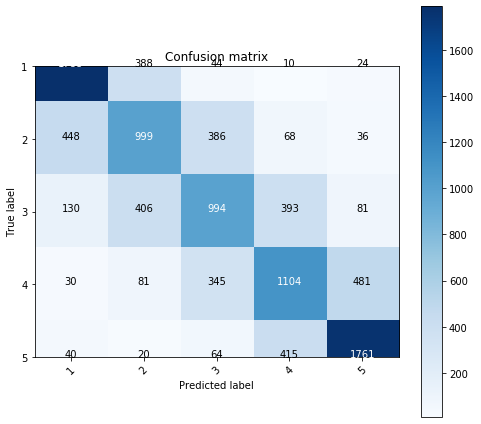

In [86]:
#Plot the Confusion Matrix
plt.figure(figsize=(7,6))
plot_confusion_matrix(cm, 
                      classes=['1', '2', '3', '4', '5'],
                      title='Confusion matrix')


## Ensemble Classifiers

An attempt to ensemble two algorithms such as Logistic Regression and Naive Bayes to improve the accuracy. The ensemble learning is one of the advanced techniques for few types of datasets. Here, logistic Regression was considered as it provides the highest accuracy (61.23) amongst few algorithms such as Naive Bayes, Adaboost Classifier, XGBoost classifier, RandomForest classifier. Consideration of Naive Bayes (59.003) as the second algorithm depending on its accuracy rankings amongst the few selected classifiers.  

### TFIDF for Logistic Regression and Naive Bayes 

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer 

vectorizer = TfidfVectorizer(lowercase = True,analyzer = 'word',ngram_range = (1,2), min_df=3, max_df=.99)
    
train_review = vectorizer.fit_transform(lab_data['text'])

In [118]:
X_train, X_test, y_train, y_test = train_test_split(train_review, lab_data['label'],test_size=0.20, random_state=1)

### First model:
#### Logistic Regression:
The Logistic Regression model takes the following parameters:
- random_state- which defines the result to be constant by setting it to one.
- C -Inverse of regularization strength set to a lower value as it specifies stronger regularization
- solver is set to SAG (Stochastic Average Gradient) method, which optimizes the sum of a finite number of smooth convex functions.
- multinomial - as there exists a total of 5 classes or labels<br>
For Accuracy classification score, Accuracy_score was used from sklean. metrics as there exists multiclass labels. 

In [119]:
log_model = LogisticRegression(random_state=1, C=1, solver='sag', multi_class = 'multinomial')
# Fitting of Logistic model to the split dataset 
log_model.fit(X_train, y_train)
# Prediction of target variables of text data using the built logistic model
y_pred = log_model.predict(X_test)
#Accuracy score
print("Accuracy of logistic Regression model:", metrics.accuracy_score(y_test, y_pred))

Accuracy of logistic Regression model: 0.6113


### Second model:
#### Naive Bayes:
- Here, the data is split using a better version that KFold and that would be stratified KFold with 10 splits, where it retains the percentage amount of the split samples for each label.
- GridSearchCV: provides  optimal parameters and combies with the grid search for fine-tuning the parameters.



In [120]:
# Function returns the gridsearch by inheriting the model classifier
def instantiate_cross_val(model):
    # 10 fold data splits performed
    stat_kfold = StratifiedKFold(n_splits=10)
    params = {}
    multi_nb = model #Multinominal Naive Bayes classifier
    grid_sear_op = GridSearchCV(multi_nb, cv=stat_kfold, param_grid=params, return_train_score=False)
    return grid_sear_op # returns gridsearch  with Naive Bayes Classifier

In [121]:
from sklearn.naive_bayes import MultinomialNB
# Multinominal Naive Bayes model
model = MultinomialNB()
# Creation of Grid Search with multinominal Naive Bayes classifier
grid_search_nb = instantiate_cross_val(model)
# Fitting the splitted data with built Naive Bayes model 
nb_fit = grid_search_nb.fit(X_train, y_train)
# Prediction of target variables of text data using the built Naive Bayes model
predicted_nb= nb_fit.predict(X_test)
#Accuracy score
print("Accuracy of Multinomial Naive Bayes :",metrics.accuracy_score(y_test, predicted_nb))

Accuracy of Multinomial Naive Bayes : 0.5537


### Ensemble Voting Classifier
Multiple machine learning algorithms can be combined and obtain improved classification results. One of the simple and effective type of ensemble learning is Voting classifer. Here, two sub models such as Logistic Regression and Naive Bayes are built, fit and predicted. The sub-models are combined and each model votes on what the output label might be.


In [122]:

#Dictionary of the models built
model_estimators=[('nb', nb_fit), ('log_reg', log_model)]
#Voting Classifer with the models as input
ensemble = VotingClassifier(model_estimators, voting='soft')

Here, soft voting is chosen as it would help to produce the probabilites of the predicted values from the Voting Classifer

In [123]:
#fit model to the split training data
ensemble.fit(X_train, y_train)
# Prediction of target variables of text data using the voting classifier
emsem_pred=ensemble.predict(X_test)
#test the score of the voting classifier model
print("Accuracy of the ensembled classifiers:",ensemble.score(X_test, y_test))

Accuracy of the ensembled classifiers: 0.6016


### Predict in Unlabeled data

In [124]:
remaining_unlabeled = unlabeled_data.copy() # copy of the unlabeled data

In [125]:
# Two iterations for better results
for iteration in range(2):
    print("\nITERATION:",iteration+1)
    #Encoded vector with count vectors of the given text data
    unlabeled_test = vectorizer.transform(remaining_unlabeled['text']) 
    #Prediction with the ensembled classifier
    pred_class = ensemble.predict(unlabeled_test)
    # Probabilties of the predicted values
    pred_probab = ensemble.predict_proba(unlabeled_test)
    p_test = []
    #Creating a lost with maximum probabilities of each class 
    for i in range(len(pred_probab)):
        p_test.append(max(pred_probab[i]))
    remaining_unlabeled['label'] = pred_class
    remaining_unlabeled['probability'] = p_test
    # Considering entries with probability more than 0.97
    new_train_data = remaining_unlabeled[remaining_unlabeled['probability'] > 0.97]
    # entries with probability more than 0.97
    print("length of obtained train data:", len(new_train_data)) 
    
    remaining_unlabeled = remaining_unlabeled[remaining_unlabeled['probability'] <= 0.97]
    # entries with probability less than 0.97
    print("length of remaining data:", len(remaining_unlabeled))
    
    new_train_data.drop(['probability'], axis=1, inplace=True)
    remaining_unlabeled.drop(['probability','label'], axis=1, inplace=True)
    
    if iteration == 0:
        train_data = pd.concat([lab_data, new_train_data])
        print("length of train data:", len(train_data))
    else:
        td = train_data.copy()
        train_data = pd.concat([td, new_train_data])
        print("length of train data:", len(train_data))
    #TFIDF for the new unlabeled data
    vectorizer = TfidfVectorizer(lowercase = True,analyzer = 'word',ngram_range = (1,2), min_df=3, max_df=.99)
    train = vectorizer.fit_transform(train_data['text'])
    X_train, X_test, y_train, y_test = train_test_split(train, train_data['label'],test_size=0.20, random_state=1)
    # Following all the prior process of building two models:
    #First model: Logistic Regression model on unlabeled data
    log_model = LogisticRegression(random_state=1, C=1, solver='sag', multi_class = 'multinomial')
    log_model.fit(X_train, y_train)
    y_pred = log_model.predict(X_test)
    print("Accuracy of logistic Regression model on unlabeled data:", metrics.accuracy_score(y_test, y_pred))
    #Second model: Multinominal Naive bayes model on unlabeled data
    model = MultinomialNB()
    grid_search_nb = instantiate_cross_val(model)

    nb_fit = grid_search_nb.fit(X_train, y_train)
    predicted_nb= nb_fit.predict(X_test)

    print("Accuracy of Multinomial Naive Bayes on unlabeled data :",metrics.accuracy_score(y_test, predicted_nb))
    model_estimators=[('nb', nb_fit), ('log_reg', log_model)]
    # Ensemble Voting classifer
    ensemble = VotingClassifier(model_estimators, voting='soft')
    #fit ensembled model to training unlabeled data
    ensemble_fit=ensemble.fit(X_train, y_train)
    #Test ensembled  model on the test data
    print("Accuracy of the ensembled classifiers on unlabeled data:",ensemble.score(X_test, y_test))
    


ITERATION: 1
length of obtained train data: 955
length of remaining data: 599045
length of train data: 50955
Accuracy of logistic Regression model on unlabeled data: 0.6141693651260917
Accuracy of Multinomial Naive Bayes on unlabeled data : 0.5568638995191836
Accuracy of the ensembled classifiers on unlabeled data: 0.6032774016288882

ITERATION: 2
length of obtained train data: 1261
length of remaining data: 597784
length of train data: 52216
Accuracy of logistic Regression model on unlabeled data: 0.6287820758330142
Accuracy of Multinomial Naive Bayes on unlabeled data : 0.5483531214094217
Accuracy of the ensembled classifiers on unlabeled data: 0.6077173496744542


# Neural Networks (TFIDF)

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer 

vectorizer = TfidfVectorizer(lowercase = True,analyzer = 'word',ngram_range = (1,2), min_df=3, max_df=.99)
    
train_review = vectorizer.fit_transform(lab_data['text'])

- In the module tensorflow, two different seeds are provided such as  global seed  and operation seed






In [98]:
seed(1)
tf.random.set_seed(1)

#### Split the data with 80:20 ratio

In [99]:
X_train, X_test, y_train, y_test = train_test_split(train_review, lab_data['label'],test_size=0.20, random_state=1)

### Neural Networks(TFIDF):
#### The Neural Networks does the following operations:
- NN creates 10 dense layers(neurons) with Rectified Linear unit as an activation function
- 6 output layers are created with softmax activation function<br>

In [100]:
#Number of features from the split train. data
input_dim = X_train.shape[1]
#Neural Network 
model = Sequential()
# Dense and output layers are created with different activation functions
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()
#Converts to class vectors to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
#Fitting of NN on  dataset
cnn_model = model.fit(X_train, y_train,
                     epochs=2,
                    verbose=False,
                     validation_data=(X_test, y_test),
                     batch_size=30)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                2374840   
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 66        
Total params: 2,374,906
Trainable params: 2,374,906
Non-trainable params: 0
_________________________________________________________________


In [101]:
#function to calculate accuracy
def acc(y_true, y_pred):
    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()


In [102]:
#Prediction with NN model
y_pred = model.predict(X_test)

In [103]:
#printing accuracy of Neural networks with tfidf
print("Accuracy of NN with TFIDF: " + str(acc(y_test, y_pred)))

Accuracy of NN with TFIDF: 0.6208


In [104]:
#making a copy of the unlabeled_data
remaining_unlabeled = unlabeled_data.copy()

In [105]:
#Encoded vector with count vectors of the given text data
unlabeled_test = vectorizer.transform(remaining_unlabeled['text'])
#Prediction with the NN 
pred_class = model.predict(unlabeled_test)
    
p_pred = []
for i in range(len(pred_class)):
    p_pred.append(argmax(pred_class[i]))
# Probabilties of the predicted values        
pred_probab = model.predict_proba(unlabeled_test)
    
p_test = []
 #Creating a lost with maximum probabilities of each class     
for i in range(len(pred_probab)):
    p_test.append(max(pred_probab[i]))
    
    
remaining_unlabeled['label'] = p_pred
remaining_unlabeled['probability'] = p_test
# Considering entries with probability more than 0.95    
new_train_data = remaining_unlabeled[remaining_unlabeled['probability'] > 0.95]
print("length of obtained train data:", len(new_train_data))
 # entries with probability more than 0.95    
remaining_unlabeled = remaining_unlabeled[remaining_unlabeled['probability'] <= 0.95]
# entries with probability less than 0.95
print("length of remaining data:", len(remaining_unlabeled))
    
new_train_data.drop(['probability'], axis=1, inplace=True)
remaining_unlabeled.drop(['probability','label'], axis=1, inplace=True)
    

train_data = pd.concat([lab_data, new_train_data])
print("length of train data:", len(train_data))
    
#TFIDF for the new unlabeled data    
vectorizer = TfidfVectorizer(lowercase = True,analyzer = 'word',ngram_range = (1,2), min_df=3, max_df=.99)
train = vectorizer.fit_transform(train_data['text'])
X_train, X_test, y_train, y_test = train_test_split(train, train_data['label'],test_size=0.20, random_state=1)
    
    
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
model.fit(X_train, y_train,
                     epochs=2,
                    verbose=False,
                     validation_data=(X_test, y_test),
                     batch_size=30)
y_pred = model.predict(X_test)
print("Accuracy of Neural Network on unlabeled data: " + str(acc(y_test, y_pred)))


length of obtained train data: 22083
length of remaining data: 577917
length of train data: 72083
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                3207330   
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 66        
Total params: 3,207,396
Trainable params: 3,207,396
Non-trainable params: 0
_________________________________________________________________
Accuracy of Neural Network on unlabeled data: 0.7386418811125754


In [106]:
y_pred_list = []
for i in range(len(y_pred)):
    y_pred_list.append(argmax(y_pred[i]))

In [107]:
y_test_list = []
for i in range(len(y_test)):
    y_test_list.append(argmax(y_test[i]))

In [108]:
#Confusion Matrix
cm_nn = confusion_matrix(y_test_list, y_pred_list)


Confusion matrix, without normalization
[[3937  344   41   10   30]
 [ 483 1086  395   62   29]
 [ 100  419  958  422   57]
 [  30   61  310 1198  426]
 [  24   13   35  477 3470]]


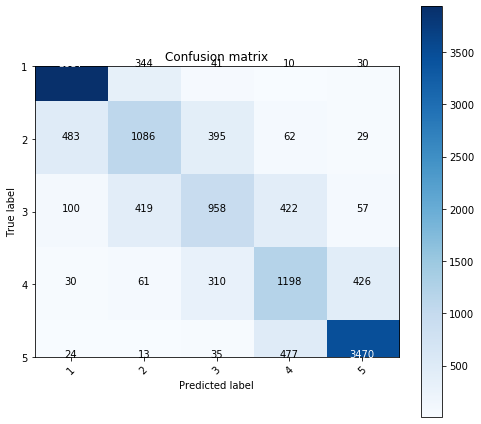

In [109]:
plt.figure(figsize=(7,6))
plot_confusion_matrix(cm_nn, 
                      classes=['1', '2', '3', '4', '5'],
                      title='Confusion matrix')

# Finalizing the model
Hence, Neural Network was chosen as it has the highest accuracy amongst the above performed models. 

In [110]:
test_data['text'] = test_data.apply(lambda row: remove_extra_characters(row['text'].strip()), axis=1) 

In [111]:
test_data['text'] = test_data.apply(lambda row: token(row['text'].strip()), axis=1)

In [112]:
#encoded Count vectors for the test data
test = vectorizer.transform(test_data['text'])

In [113]:
##Prediction using Neural Network
pred_class = model.predict(test)

In [114]:
p_pred = []
for i in range(len(pred_class)):
    p_pred.append(argmax(pred_class[i]))

In [115]:
#Creation of Predict_label dataframe 
pred_data = pd.DataFrame({'test_id':test_data['test_id'], 'label':p_pred})

In [116]:
pred_data.to_csv("predict_label.csv", index=False)

## Conclusion

In this assignment, a thorough understanding of the different  Pre-processing combinations for a text data leading to various Exploratory Data Analysis. Through EDA, the tone of the content was explored. Feature Engineering techniques was well demonstrated on the pre-processed data such as Word2Vec and TFIDF. Multiple combinations of few selected models and the feature engineering techniques leading to varied accuracies. Here, Neural Network with TFIDF provided the highest accuracy of predicting the multiclass for the given text data amongst Logistic Regression model and ensemble classifier model that includes Logistic Regression and Naive Bayes. 